In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import glob
import math
from scipy.optimize import curve_fit
import functions as model2
import emcee
from cmdstanpy import CmdStanModel

In [2]:
# Define the hazard function calculator
def hazard_function_empirical_time(df):
    generation_times = np.asarray(df["generationtime"], dtype=float)
    generation_times = generation_times[np.isfinite(generation_times)]
    generation_times = np.sort(generation_times)
    min_diff = 0.001
    for i in range(len(generation_times) - 1):
        diff = generation_times[i + 1] - generation_times[i]
        if diff < min_diff and diff > 0:
            min_diff = diff
    N_t = len(generation_times)
    t_max = np.max(generation_times)
    grid = np.arange(0, t_max + min_diff, min_diff)
    survival = [(generation_times > t).sum()/N_t for t in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for t in range(len(grid) - 1):
        hazard[t] = (-1/survival[t]) * (survival[t+1] - survival[t])/(grid[t+1] - grid[t])
    return grid, hazard/sum(hazard), survival[:-1]

def hazard_function_empirical_protein(df):
    protein_levels = np.asarray(df["protein_level"], dtype=float)
    protein_levels = protein_levels[np.isfinite(protein_levels)]
    protein_levels = np.sort(protein_levels)
    min_diff = 0.01
    N_t = len(protein_levels)
    p_max = np.max(protein_levels)
    grid = np.arange(0, p_max + min_diff, min_diff)
    survival = [(protein_levels > p).sum()/N_t for p in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for p in range(len(grid) - 1):
        if survival[p] > 0 and survival[p+1] > 0:   #Checking division by zero
            hazard[p] = - (np.log(survival[p+1]) - np.log(survival[p])) / (grid[p+1] - grid[p])
        else:
            hazard[p] = 0
    return grid, hazard/sum(hazard), survival[:-1]


def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)

In [3]:
#Make a dictionary of dataframes
dfs = {}
names = []                                              
for path in glob.glob("data/*.csv"):
    if path=="data/UMIK_allSources.csv" or path=="data/df_UMIK_allSources.csv":
        continue
    name = os.path.splitext(os.path.basename(path))[0]  
    names.append(name)
    dfs[name] = pd.read_csv(path)

# Add protein levels to the dataframes
for name, df in dfs.items():
    df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])
# We used lenght instead of mass


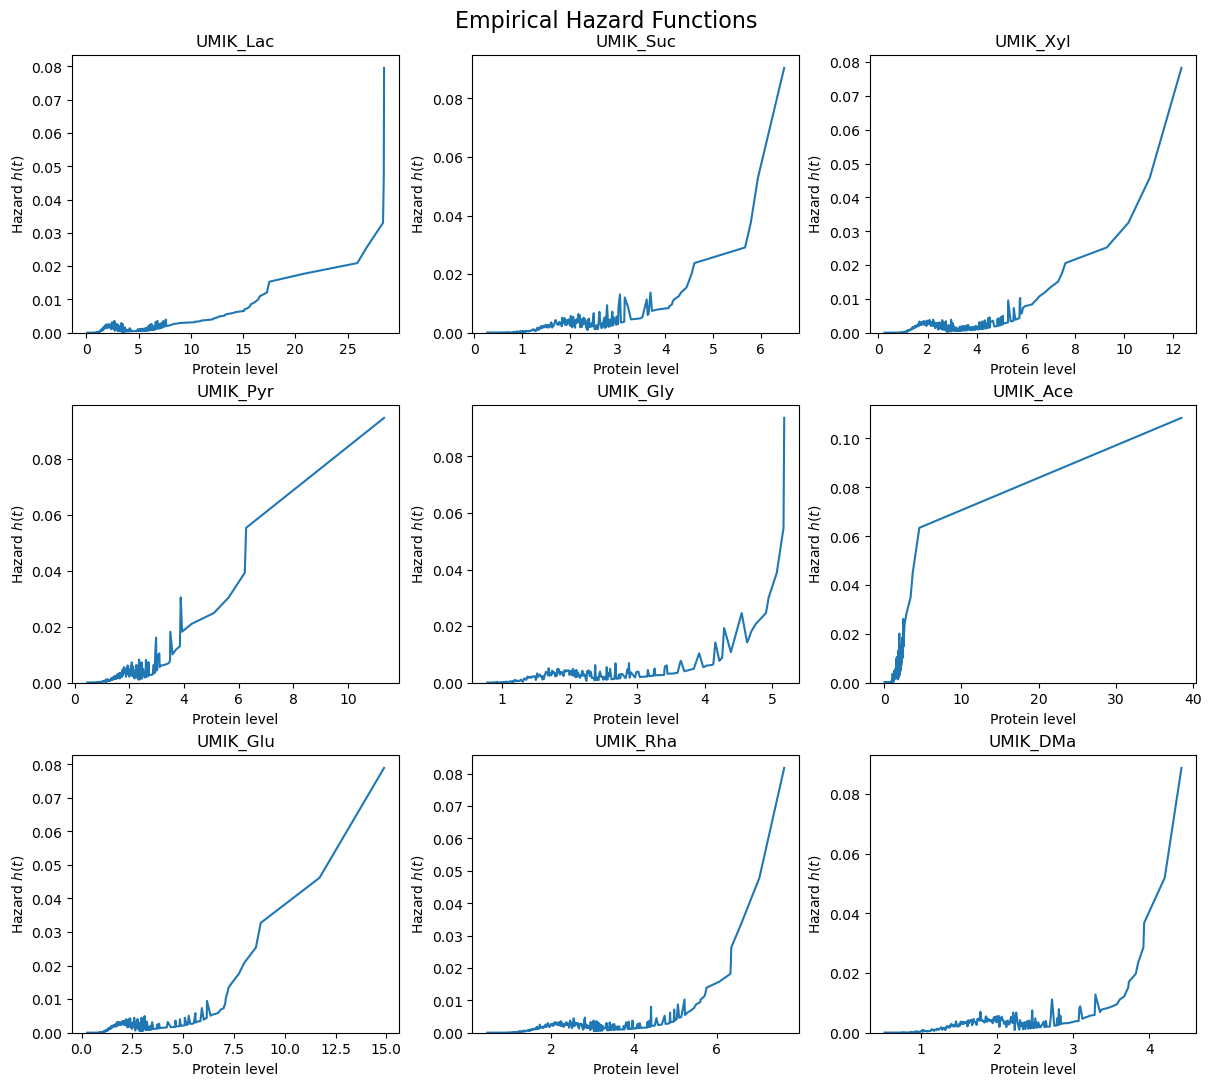

In [4]:
hazards = []                         
for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):

    """#remove extreme values
    if name == "UMIK_Ace":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]
    elif name == "UMIK_Pyr":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]"""

    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Hazard $h(t)$")
    ax.set_ylim(bottom=0)

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()

In [5]:
def logistic_survival(t, a, b):
    return 1 / (1 + np.exp(a * (t - b)))

def generalized_logistic_survival(t, tau, k, alpha):
    return 1 / (1 + (t / tau)**k)**alpha

def generalized_logistic_hazard(t, tau, k, alpha):
    t = np.asarray(t)
    term = (t / tau)
    numerator = alpha * k / tau * term**(k - 1)
    denominator = 1 + term**k
    return numerator / denominator

# Survival and Hazard funciton as a funcion of protein level

$S(p) = \frac{1}{\left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a}}$

$h(p) = \frac{a k}{\tau^k} \cdot \frac{\left( \frac{p}{\tau} \right)^{k-1}}{1 + \left( \frac{p}{\tau} \right)^k}$

$f(p) = \frac{a \cdot k \cdot p^{k-1}}{\tau^k \left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a + 1}}$

$p$: independent variable (protein level)

$\tau$: inflection point (location)

$k$: shape/steepness

$a$: scale or tail weight parameter

# Survival and Hazard funciton as a funcion of time

$p(t) = c m_D \left(e^{\alpha t} - 1\right)$ : Protein growth as a function of time $t$


$S(t) = \frac{1}{\left(1 + \left( \frac{c m_D (e^{\alpha t} - 1)}{\tau} \right)^k \right)^{\alpha}}$

$h(t) = \left[ \frac{\alpha k}{\tau} \cdot \frac{\left( \frac{p(t)}{\tau} \right)^{k-1}}{1 + \left( \frac{p(t)}{\tau} \right)^k} \right] \cdot c m_D \alpha e^{\alpha t}$

/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_1173/2431327484.py:5: RuntimeWarning: invalid value encountered in power
  return 1 / (1 + (t / tau)**k)**alpha


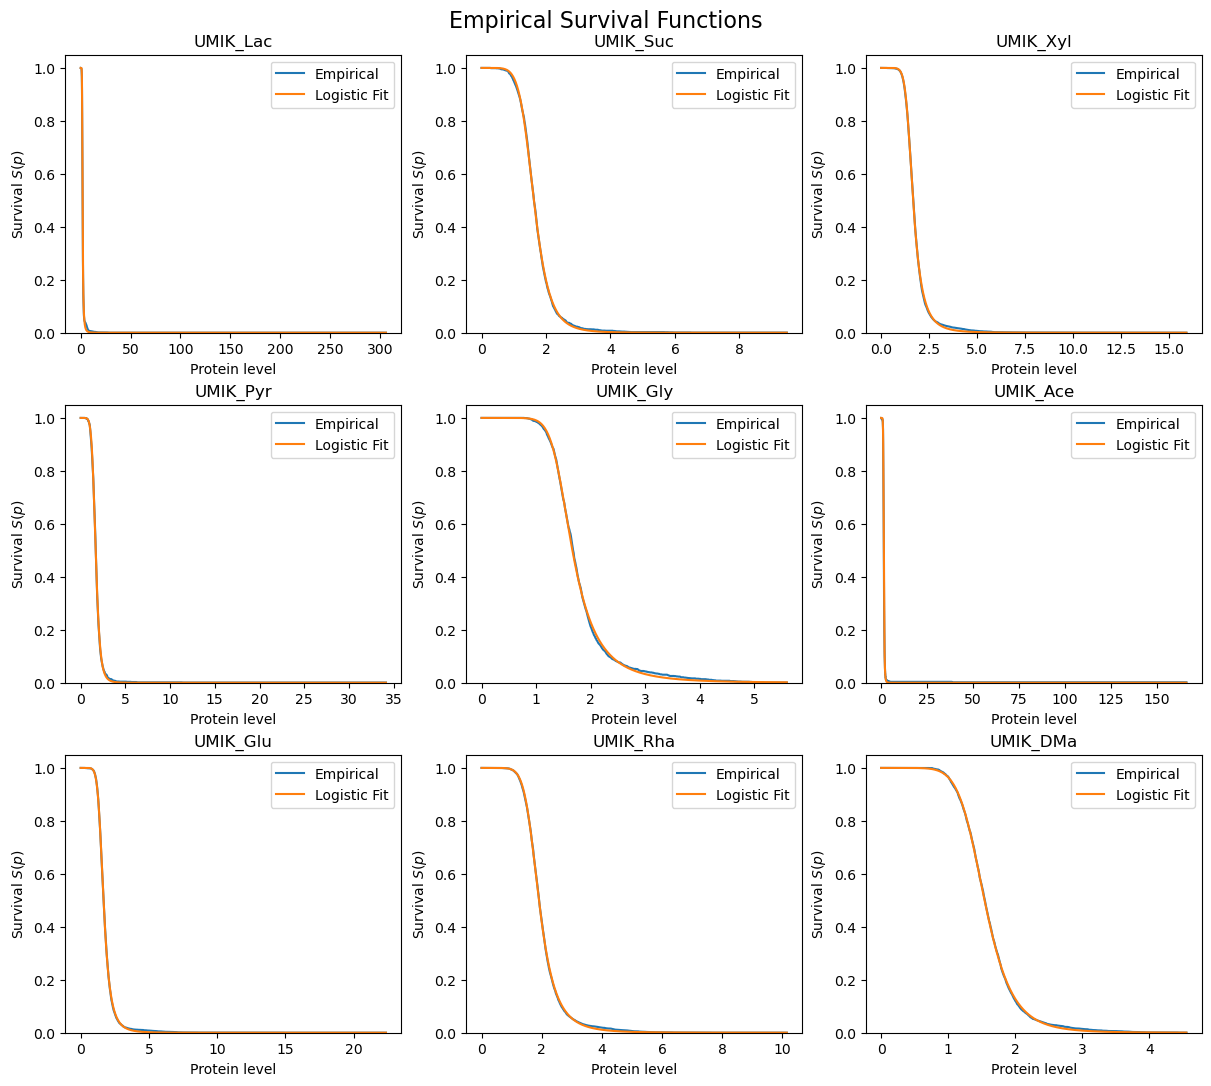

In [6]:
hazards = []                         

for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    hazards.append((name, grid[:-1], h, survival))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               
fittingParams = []

for ax, (name, grid, h, survival) in zip(axes, hazards):

    popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
    grid_fit = np.linspace(min(grid), max(grid), len(grid))
    survival_fit = generalized_logistic_survival(grid_fit, *popt)
    fittingParams.append(popt)
    
    ax.plot(grid, survival, lw=1.5, label='Empirical')
    ax.plot(grid_fit, survival_fit, label='Logistic Fit')

    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Survival $S(p)$")
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Survival Functions", fontsize=16, y=1.02)
plt.show()

fittingParams = pd.DataFrame(fittingParams)
fittingParams.columns = ["T", "k", "a"]

In [26]:
fittingParams

,T,k,a
0,1.597620,9.063562,0.402818
1,1.627688,6.695966,1.008939
2,1.503213,9.204902,0.543990
3,1.696184,6.879143,1.061840
4,1.486226,9.994281,0.487794
5,1.433339,8.987700,0.845285
6,1.545813,8.273218,0.643941
7,1.777104,8.197598,0.675169
8,1.520874,7.688450,0.926811


In [7]:
fittingParams['T'][8]

1.5208737752313588

Text(0.5, 1.0, 'Fitting parameters')

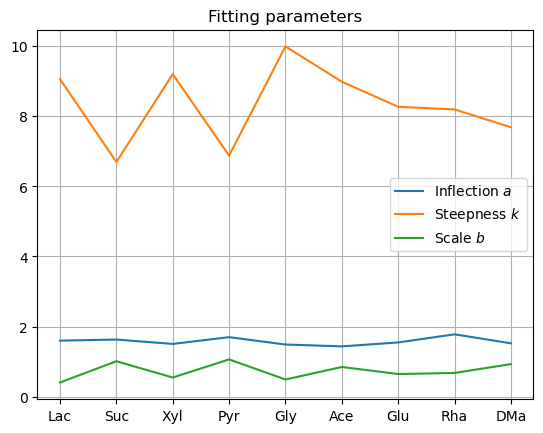

In [21]:
sugars = ["Lac", "Suc", "Xyl", "Pyr", "Gly", "Ace", "Glu", "Rha", "DMa"]

plt.plot(fittingParams["T"], label ='Inflection $a$')
plt.plot(fittingParams["k"], label ='Steepness $k$')
plt.plot(fittingParams["a"], label ='Scale $b$')

plt.legend()
plt.grid()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8], labels = sugars)
plt.title("Fitting parameters")

In [29]:
print(fittingParams.iloc[0])
print(fittingParams.iloc[5])

T    1.597620
k    9.063562
a    0.402818
Name: 0, dtype: float64
T    1.433339
k    8.987700
a    0.845285
Name: 5, dtype: float64


Text(0.5, 1.0, 'Scatter Plot of Fitting Parameters T - k')

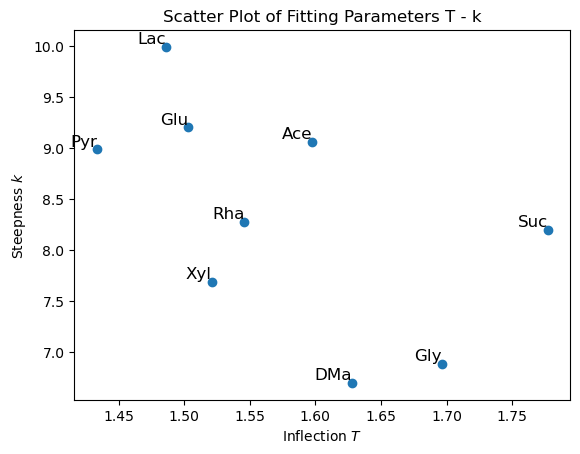

In [9]:
T = fittingParams["T"]
k = fittingParams["k"]
a = fittingParams["a"]

plt.scatter(T,k)
for i, label in enumerate(sugars):
    plt.text(T[i], k[i], label, fontsize=12, ha='right', va='bottom')
plt.xlabel('Inflection $T$')
plt.ylabel('Steepness $k$')
plt.title('Scatter Plot of Fitting Parameters T - k')

# Hazard function from survial fit (DMa)

In [10]:
grid = hazards[1][1]
h = hazards[1][2]
survival = hazards[1][3]

In [11]:
popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
grid_fit = np.linspace(min(grid), max(grid), len(grid))
survival_fit = generalized_logistic_survival(grid_fit, *popt)

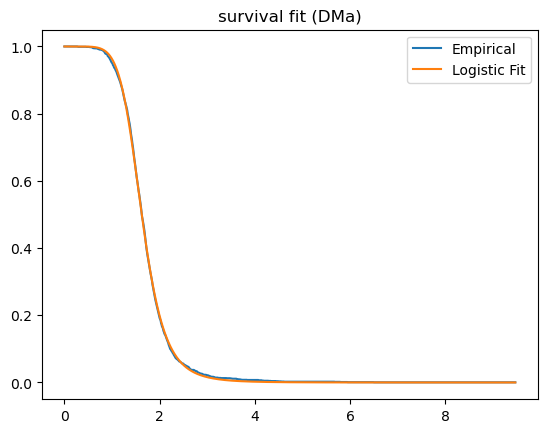

In [12]:
plt.plot(grid, survival, lw=1.5, label='Empirical')
plt.plot(grid_fit, survival_fit, label='Logistic Fit')
plt.title("survival fit (DMa)")
plt.legend()

In [13]:
hazard = np.empty(len(grid)-1, dtype=float)
for p in range(len(grid) - 1):
    if survival_fit[p] > 0 and survival_fit[p+1] > 0:
        hazard[p] = - (np.log(survival_fit[p+1]) - np.log(survival_fit[p])) / (grid_fit[p+1] - grid_fit[p])
    else:
        hazard[p] = 0

Text(0.5, 1.0, 'hazard from survival fit (DMa)')

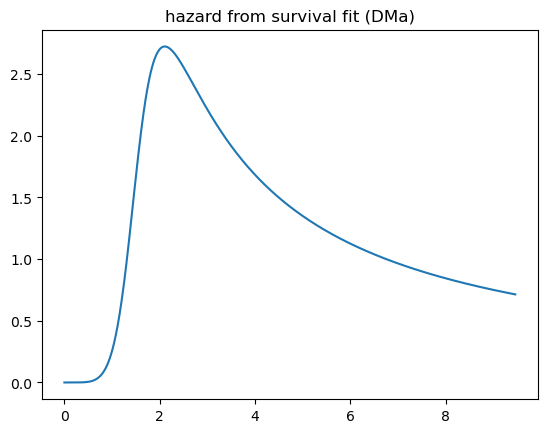

In [14]:
plt.plot(grid_fit[:-1],hazard)
plt.title("hazard from survival fit (DMa)")

In [15]:
u = grid_fit

log_l_vals=np.empty(u.shape[0])

for i,u_i in enumerate(u):
    params_val = [u_i ,v_true,omega2_true,alpha2_true,beta2_true,alpha1_true,scale1_true]
    log_l_vals[i]=model2.log_likelihood(params_val,initial_mass,lineagest,timest,alphast,fst)


plt.plot(u,log_l_vals ,lw=2, ls='dashed', color='blue',  label='')
plt.title("Likelihood with u variable")
plt.ylabel(" log(likelihood) value")
plt.xlabel(" u value")
plt.show()
print("True values:", initial_values)

NameError: name 'v_true' is not defined

In [16]:
def protein_levels_at_division_pdf(p, alpha, k, tau):
    # Compute the probability density function (PDF) of the protein levels
    return (alpha * k/(tau**k)) * (p**(k-1)) / ((1 + (p/tau)**k)**(alpha + 1))


In [17]:
def metropolis_hastings(unnorm_pdf, alpha, k, tau, n_samples=100000, proposal_width=1.0, burn_in=50000):
    samples = []
    p_current = np.random.rand() + 0.1  # initial value > 0
    for _ in range(n_samples + burn_in):
        p_proposal = np.random.normal(p_current, proposal_width)
        if p_proposal <= 0:
            continue  # stay in domain

        # Acceptance probability
        p_accept = min(1, unnorm_pdf(p_proposal, alpha, k, tau) / unnorm_pdf(p_current, alpha, k, tau))

        if np.random.rand() < p_accept:
            p_current = p_proposal

        samples.append(p_current)

    return np.array(samples[burn_in:])



### Sampling with determistic parameters

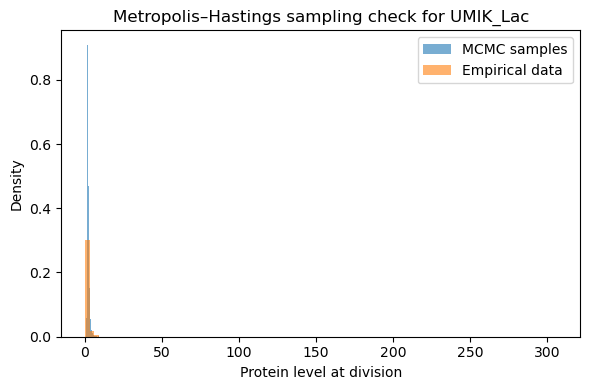

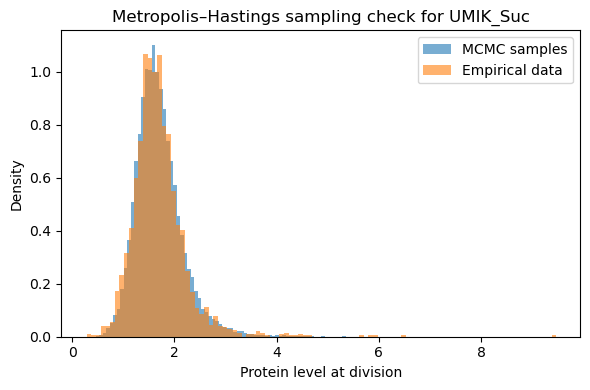

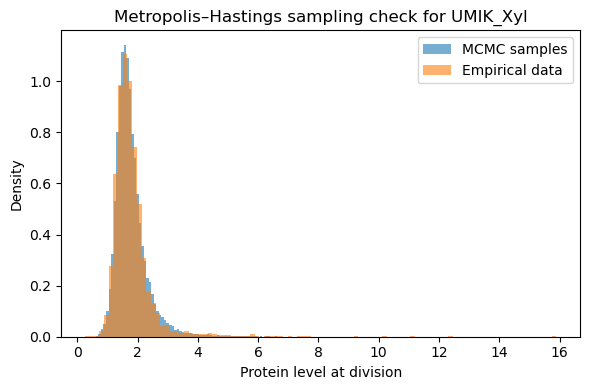

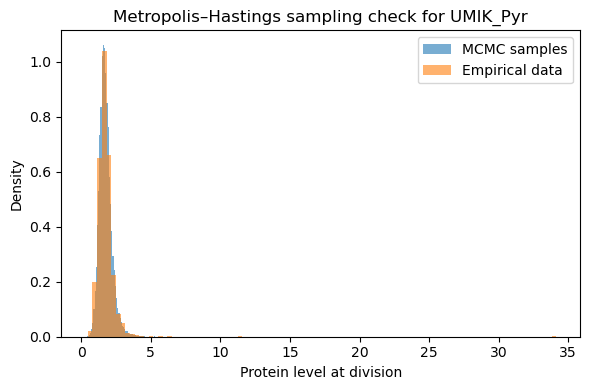

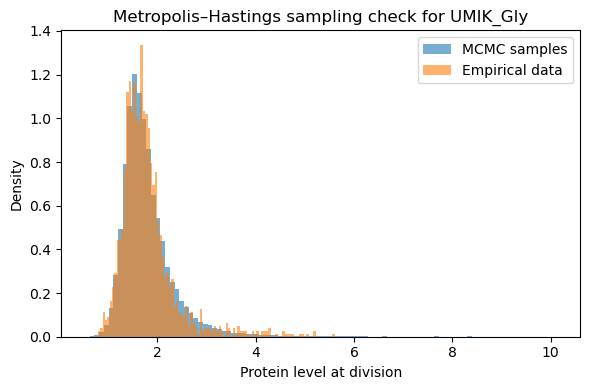

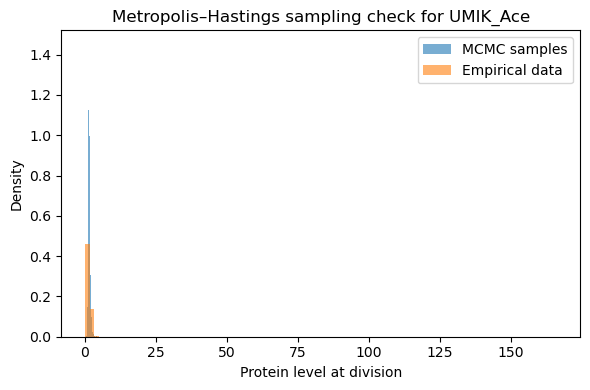

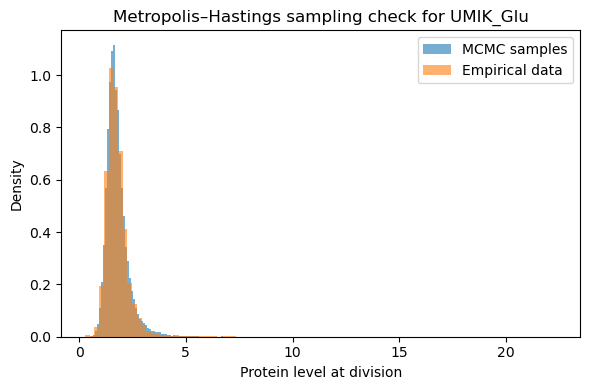

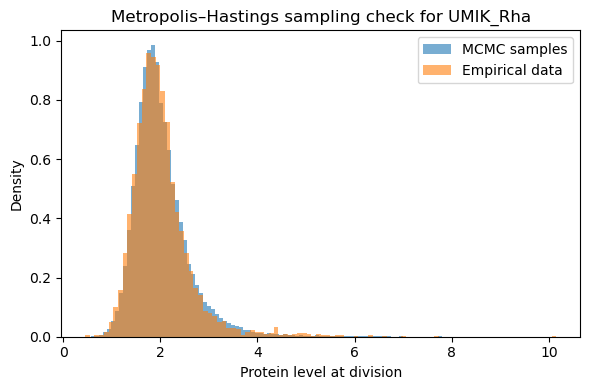

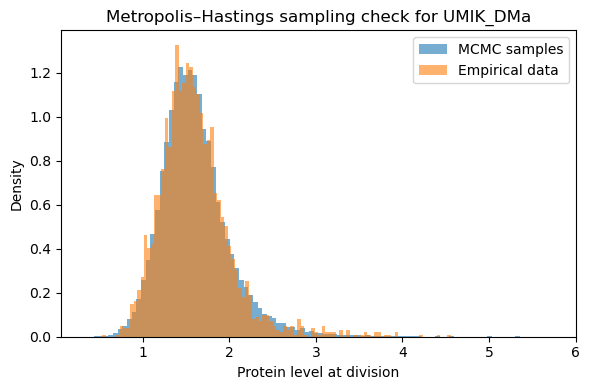

In [18]:
for i in range(len(fittingParams['a'])):
    alpha, k, tau = fittingParams['a'][i], fittingParams['k'][i] , fittingParams['T'][i]
    samples = metropolis_hastings(protein_levels_at_division_pdf, alpha, k, tau)

    posterior_samples = samples
    empirical_protein_level = dfs[names[i]]["protein_level"]
    plt.figure(figsize=(6, 4))
    plt.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
    plt.hist(empirical_protein_level, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')

    plt.xlabel("Protein level at division")
    plt.ylabel("Density")
    plt.title(f"Metropolis–Hastings sampling check for {names[i]}")
    plt.legend()
    plt.tight_layout()

In [30]:

stan_model_code = """
functions {
  real log_protein_pdf(real p, real alpha, real k, real tau) {
    return log(alpha)
         + log(k)
         - k * log(tau)
         + (k - 1) * log(p)
         - (alpha + 1) * log1p(pow(p / tau, k));
  }
}
data {
  int<lower=1> N;
  vector<lower=1e-8>[N] p;
}
parameters {
  real<lower=1e-6, upper=1e6> alpha;
  real<lower=1e-6, upper=1e6> k;
  real<lower=1e-6, upper=1e6> tau;
}
model {
  for (n in 1:N)
    target += log_protein_pdf(p[n], alpha, k, tau);
}
"""

In [31]:
with open("protein_model.stan", "w") as f:
    f.write(stan_model_code)


In [32]:
model = CmdStanModel(stan_file="protein_model.stan")

14:22:47 - cmdstanpy - INFO - compiling stan file /var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/tmphvnq7f3t/tmpskpap8lx.stan to exe file /Users/test/Desktop/Master semester 2/LCP B/PoD_microbial_growth/Code/PoD_microbial_growth_repo/protein_model
14:22:58 - cmdstanpy - INFO - compiled model executable: /Users/test/Desktop/Master semester 2/LCP B/PoD_microbial_growth/Code/PoD_microbial_growth_repo/protein_model


In [33]:
n_walkers = 12       # ≥2×dim
ndim      = 3
init_pos  = np.random.randn(n_walkers, ndim)  

samples_dict = {}
for name in names:
    protein_levels = dfs[name]["protein_level"].dropna().values
    protein_levels = protein_levels[protein_levels > 0] 

    stan_data = {
        "N": len(protein_levels),
        "p": protein_levels
    }

    # write Stan code to a file
    with open("protein_model.stan", "w") as f:
        f.write(stan_model_code)   # assume `stan_model_code` holds the model string

    # compile and sample
    fit = model.sample(data=stan_data,
                        chains=4,
                        iter_sampling=400,
                        iter_warmup=1000,
                        thin=4,
                        show_progress=True)

    # extract posterior samples
    samples = fit.draws_pd()
    print(samples.head())

    # store samples in the dictionary
    samples_dict[name] = samples[["alpha", "k", "tau"]]

14:25:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:27:46 - cmdstanpy - INFO - CmdStan done processing.
14:27:46 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -6010.89       0.991033    0.284718          3.0   
1      1.0     2.0     2.0 -6008.56       0.987397    0.284718          3.0   
2      1.0     3.0     3.0 -6008.61       0.888745    0.284718          2.0   
3      1.0     4.0     4.0 -6008.91       0.998639    0.284718          2.0   
4      1.0     5.0     5.0 -6008.67       0.995848    0.284718          4.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           7.0          0.0   6011.56  0.433314  8.23110  1.60295  
1          15.0          0.0   6009.50  0.441659  8.09855  1.61755  
2           3.0          0.0   6011.35  0.443450  8.01305  1.62061  
3           3.0          0.0   6009.51  0.447443  7.95491  1.62545  
4          15.0          0.0   6009.15  0.460342  7.94219  1.63075  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:29:18 - cmdstanpy - INFO - CmdStan done processing.
14:29:18 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -1822.78       0.999705    0.027251          6.0   
1      1.0     2.0     2.0 -1823.88       0.840927    0.027251          5.0   
2      1.0     3.0     3.0 -1824.36       0.998139    0.027251          7.0   
3      1.0     4.0     4.0 -1825.01       0.970664    0.027251          2.0   
4      1.0     5.0     5.0 -1823.70       0.969367    0.027251          6.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0          63.0          0.0   1824.35  530220.0  2.79223  210.569  
1          55.0          0.0   1826.53  443771.0  2.79845  197.692  
2         127.0          0.0   1826.38  785881.0  2.75053  261.951  
3           7.0          0.0   1825.21  841824.0  2.85548  222.211  
4          99.0          0.0   1825.77  655302.0  2.81447  216.795  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:37:20 - cmdstanpy - INFO - CmdStan done processing.
14:37:20 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -7109.70       0.999041    0.011241          7.0   
1      1.0     2.0     2.0 -7110.49       0.944347    0.011241          6.0   
2      1.0     3.0     3.0 -7110.79       0.996330    0.011241          8.0   
3      1.0     4.0     4.0 -7110.81       0.955115    0.011241          7.0   
4      1.0     5.0     5.0 -7112.22       0.969013    0.011241          9.0   

   n_leapfrog__  divergent__  energy__     alpha        k       tau  
0         247.0          0.0   7112.93  619007.0  2.46700  446.1150  
1          79.0          0.0   7112.15  823406.0  2.45678  507.0730  
2         355.0          0.0   7112.11  918911.0  2.46981  517.3930  
3         167.0          0.0   7113.57  677515.0  2.47105  454.1640  
4        1023.0          0.0   7112.54   13828.3  2.46614   95.6214  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:37:57 - cmdstanpy - INFO - CmdStan done processing.
14:37:57 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -913.923       1.000000    0.276278          2.0   
1      1.0     2.0     2.0 -913.707       0.906189    0.276278          2.0   
2      1.0     3.0     3.0 -913.665       0.862360    0.276278          3.0   
3      1.0     4.0     4.0 -914.185       0.594044    0.276278          2.0   
4      1.0     5.0     5.0 -913.088       0.914677    0.276278          2.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           3.0          0.0   915.879  0.988935  6.99486  1.65579  
1           3.0          0.0   915.612  1.014140  6.93011  1.67117  
2          15.0          0.0   915.284  0.957978  6.97026  1.67808  
3           7.0          0.0   916.689  0.854855  7.34945  1.64192  
4           7.0          0.0   913.640  0.837427  7.35950  1.62851  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:39:03 - cmdstanpy - INFO - CmdStan done processing.
14:39:03 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -961.583       0.778098    0.196226          2.0   
1      1.0     2.0     2.0 -961.772       0.967826    0.196226          2.0   
2      1.0     3.0     3.0 -963.482       0.641227    0.196226          2.0   
3      1.0     4.0     4.0 -961.777       0.997400    0.196226          3.0   
4      1.0     5.0     5.0 -962.296       0.993624    0.196226          2.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           3.0          0.0   962.224  0.503330  9.51320  1.50269  
1           3.0          0.0   961.826  0.507278  9.70093  1.48271  
2           3.0          0.0   965.930  0.526513  9.76263  1.49070  
3          15.0          0.0   966.924  0.547301  9.32065  1.52307  
4           7.0          0.0   962.401  0.580119  8.91066  1.53172  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:39:20 - cmdstanpy - INFO - CmdStan done processing.
14:39:20 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -938.941       0.960733    0.038809          2.0   
1      1.0     2.0     2.0 -939.288       0.972999    0.038809          6.0   
2      1.0     3.0     3.0 -940.217       0.999757    0.038809          6.0   
3      1.0     4.0     4.0 -942.829       0.999435    0.038809          6.0   
4      1.0     5.0     5.0 -939.490       0.989212    0.038809          7.0   

   n_leapfrog__  divergent__  energy__     alpha        k       tau  
0           3.0          0.0   939.459  634743.0  1.03477  803072.0  
1         127.0          0.0   940.673  436251.0  1.01156  733976.0  
2          63.0          0.0   941.281  898853.0  1.04954  910028.0  
3          63.0          0.0   942.987  941625.0  1.04463  991724.0  
4         127.0          0.0   940.139  261484.0  1.06381  236711.0  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:42:12 - cmdstanpy - INFO - CmdStan done processing.
14:42:12 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -4085.49       0.901608    0.141848          3.0   
1      1.0     2.0     2.0 -4086.11       0.929578    0.141848          3.0   
2      1.0     3.0     3.0 -4084.35       0.916255    0.141848          3.0   
3      1.0     4.0     4.0 -4085.15       0.912598    0.141848          3.0   
4      1.0     5.0     5.0 -4086.97       0.827514    0.141848          3.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           7.0          0.0   4085.71  0.576140  8.44519  1.51262  
1          15.0          0.0   4088.37  0.592018  8.28442  1.51776  
2          11.0          0.0   4085.52  0.597743  8.51188  1.52586  
3           7.0          0.0   4088.49  0.586280  8.44565  1.51299  
4          15.0          0.0   4089.37  0.610485  8.12555  1.52973  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:47:23 - cmdstanpy - INFO - CmdStan done processing.
14:47:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.5%)
	Chain 4 had 1 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
14:47:23 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -3534.53       0.996372    0.001477          5.0   
1      1.0     2.0     2.0 -3534.53       0.999514    0.001477          3.0   
2      1.0     3.0     3.0 -3534.71       0.965669    0.001477          4.0   
3      1.0     4.0     4.0 -3535.55       0.999785    0.001477          6.0   
4      1.0     5.0     5.0 -3535.28       0.933562    0.001477          3.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0          43.0          0.0   3535.16  0.643642  8.32408  1.76256  
1           7.0          0.0   3534.60  0.658883  8.10456  1.77331  
2          15.0          0.0   3535.03  0.657651  8.12291  1.76127  
3          87.0          0.0   3536.39  0.645126  8.29589  1.77207  
4          15.0          0.0   3536.49  0.631224  8.32257  1.76188  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:49:24 - cmdstanpy - INFO - CmdStan done processing.



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -1066.15       0.993122    0.001836          6.0   
1      1.0     2.0     2.0 -1064.68       0.999994    0.001836          5.0   
2      1.0     3.0     3.0 -1065.80       0.942736    0.001836          4.0   
3      1.0     4.0     4.0 -1065.19       0.969302    0.001836          2.0   
4      1.0     5.0     5.0 -1065.08       0.970513    0.001836          4.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0         111.0          0.0   1068.62  0.952593  7.58653  1.52649  
1          51.0          0.0   1065.16  0.863365  7.86698  1.49892  
2          31.0          0.0   1066.05  0.830440  7.87751  1.47995  
3           3.0          0.0   1065.72  0.862066  7.99505  1.49760  
4          23.0          0.0   1065.73  0.820796  7.95027  1.49029  


In [34]:
print(samples_dict)

{'UMIK_Lac':         alpha        k      tau
0    0.433314  8.23110  1.60295
1    0.441659  8.09855  1.61755
2    0.443450  8.01305  1.62061
3    0.447443  7.95491  1.62545
4    0.460342  7.94219  1.63075
..        ...      ...      ...
395  0.449982  7.93149  1.62658
396  0.465562  7.77718  1.63361
397  0.493049  7.52549  1.64797
398  0.490570  7.59074  1.64546
399  0.449125  7.98011  1.62842

[400 rows x 3 columns], 'UMIK_Suc':         alpha        k      tau
0    530220.0  2.79223  210.569
1    443771.0  2.79845  197.692
2    785881.0  2.75053  261.951
3    841824.0  2.85548  222.211
4    655302.0  2.81447  216.795
..        ...      ...      ...
395  829340.0  2.72775  275.314
396  591457.0  2.82407  207.310
397  679533.0  2.83808  215.161
398  625123.0  2.80870  215.763
399  650475.0  2.76956  235.333

[400 rows x 3 columns], 'UMIK_Xyl':              alpha        k        tau
0    619007.000000  2.46700  446.11500
1    823406.000000  2.45678  507.07300
2    918911.000000  2.46981 

In [35]:
def log_protein_levels_pdf(p, alpha, k, tau):
    if p <= 0 or alpha <= 0 or k <= 0 or tau <= 0:
        return -np.inf

    try:
        logf = (
            np.log(alpha) +
            np.log(k) -
            k * np.log(tau) +
            (k - 1) * np.log(p) -
            (alpha + 1) * np.log1p((p / tau)**k)
        )
        return logf
    except:
        return -np.inf
    
def protein_levels_at_division_pdf(p, alpha, k, tau):
    log_val = log_protein_levels_pdf(p, alpha, k, tau)
    return np.exp(log_val) if np.isfinite(log_val) else 0

0


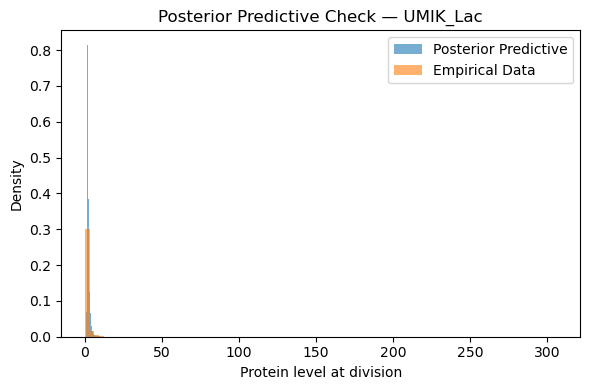

1


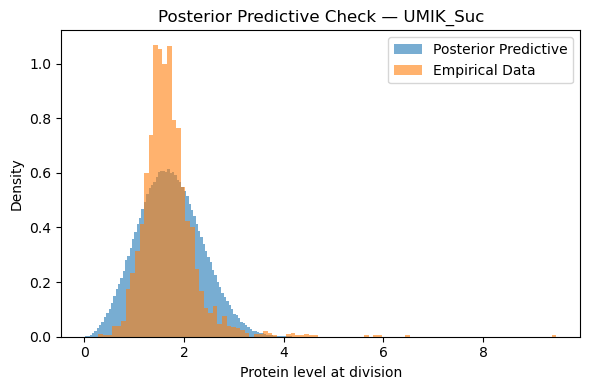

2


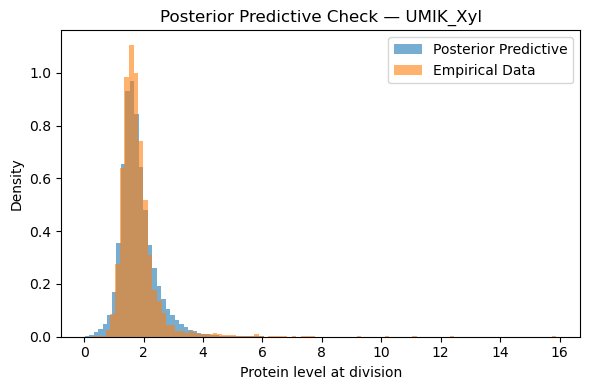

3


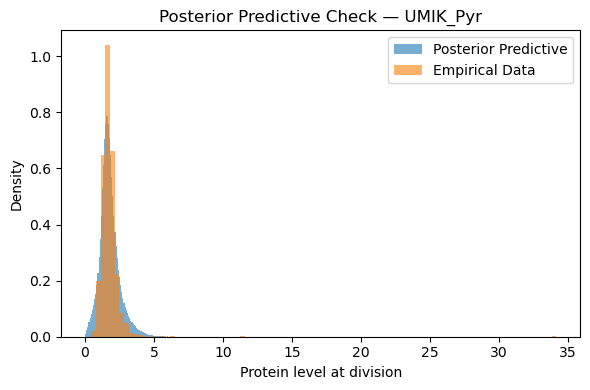

4


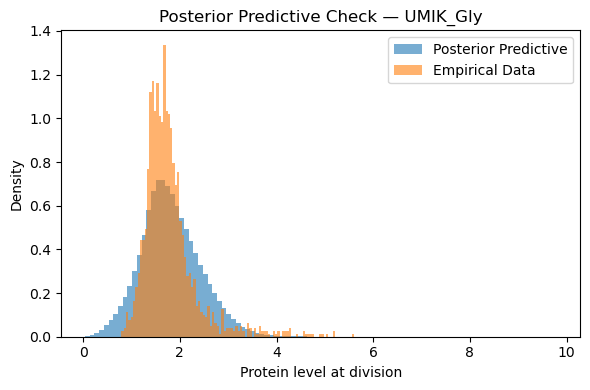

5


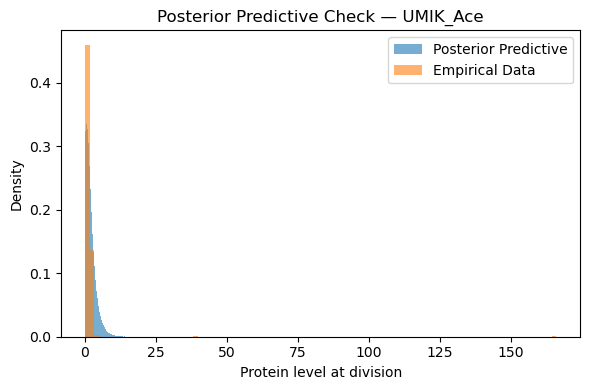

6


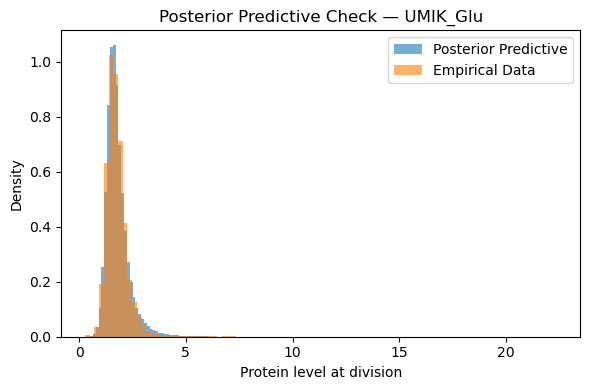

7


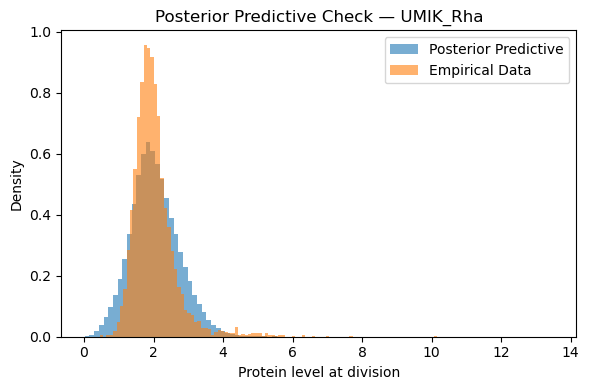

8


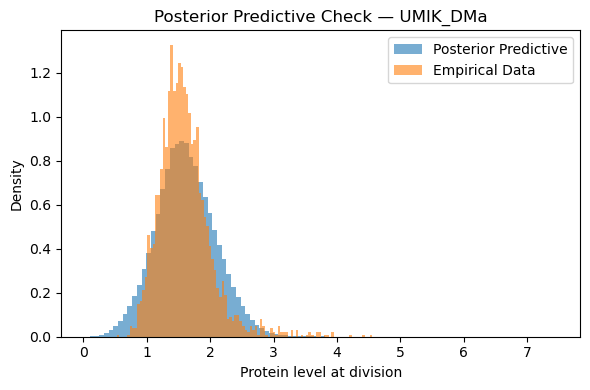

In [41]:
for i in range(len(names)):
    # Extract posterior samples (e.g. from Stan or emcee output)
    posterior_df = samples_dict[names[i]]     # shape (n_draws, 3)
    alphas = posterior_df["alpha"]
    #print("alphas:", alphas)
    ks = posterior_df["k"]
    #print("ks:", ks)
    taus = posterior_df["tau"]
    #print("taus:", taus)
    simulated = []
    # For each posterior draw, simulate a protein level
    for alpha, k, tau in zip(alphas, ks, taus):
        # sample one value using your MCMC kernel
        sample = metropolis_hastings(protein_levels_at_division_pdf, alpha, k, tau, n_samples=2000, burn_in=1000)
        #print("sample:", sample)
        simulated.extend(sample)

    simulated = np.array(simulated)
    #print(simulated)
    empirical_protein_level = dfs[names[i]]["protein_level"].dropna().values

    # Plot
    plt.figure(figsize=(6, 4))
    plt.hist(simulated, bins=100, density=True, alpha=0.6, label="Posterior Predictive", color='C0')
    plt.hist(empirical_protein_level, bins=100, density=True, alpha=0.6, label="Empirical Data", color='C1')

    plt.xlabel("Protein level at division")
    plt.ylabel("Density")
    plt.title(f"Posterior Predictive Check — {names[i]}")
    plt.legend()
    plt.tight_layout()
    print(i)
    plt.show()
    
    

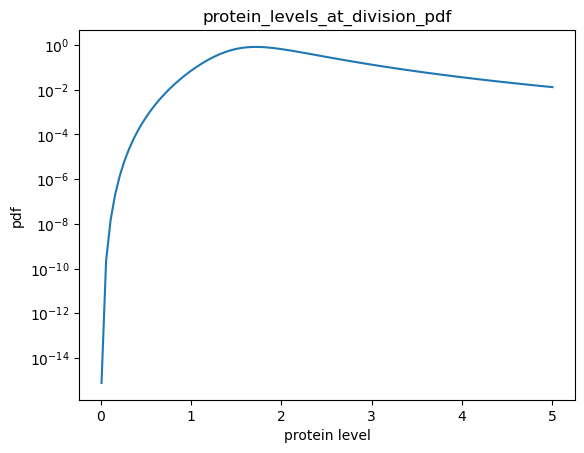

In [92]:
alpha = alphas.iloc[0]
k = ks.iloc[0]
tau = taus.iloc[0]

x_vals = np.linspace(0.01, 5, 100)
y_vals = [protein_levels_at_division_pdf(x, alpha, k, tau) for x in x_vals]

plt.plot(x_vals, y_vals)
plt.yscale('log')
plt.title("protein_levels_at_division_pdf")
plt.xlabel("protein level")
plt.ylabel("pdf")
plt.show()

### Superimposing the empirical calculation with the fit